In [1]:
%matplotlib inline

# TP1: The Interaction-driven Metal-Insulator Transition

## GOAL:	

1) To understand the difference between the electronic spectral functions of a metal and of a Mott insulator. 

2) To understand the interaction-driven metal-insulator transition in the Hubbard Model (the reference model for this problem), known as the **Mott Metal-Insulator Transition** (MIT).   

To achieve these goals you will have to understand how to read Green's function and connect them to physical properties. We will use the (exact!)  Dynamical-Mean-Field-Theory (DMFT) solution of the Hubbard Model on the infinite-dimensional Bethe lattice. The DMFT is numerically implemented using the Iterative Perturbation Theory (IPT), which provides (approximate but good) Green's functions. To this purpose you will have to run a PYTHON code, manipulating the input/output in order to simulate different physical situations and interpret the outputs. 

It would be interesting to study also the details of the DMFT implementation and the IPT impurity solver, but it will not be possible on this occasion. Use it then as a black box to perform virtual theoretical experiments.

You will have to provide us at the end of the Tutorial a complete report, answering to the questions of the section EXERCISES. Include graphs and commentaries whenever asked (or possible) at your best convenience.  


Real frequency IPT solver single band Hubbard model
===================================================
Here it is the IPT code.



In [1]:
# Author: Óscar Nájera
# License: 3-clause BSD

from __future__ import division, absolute_import, print_function
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt

plt.matplotlib.rcParams.update({'axes.labelsize': 22,
                                'axes.titlesize': 22, })


def fermi_dist(energy, beta):
    """ Fermi Dirac distribution"""
    exponent = np.asarray(beta * energy).clip(-600, 600)
    return 1. / (np.exp(exponent) + 1)


def semi_circle_hiltrans(zeta, D=1):
    """Calculate the Hilbert transform with a semicircular DOS """
    sqr = np.sqrt(zeta**2 - D**2)
    sqr = np.sign(sqr.imag) * sqr
    return 2 * (zeta - sqr) / D**2


def pertth(Aw, nf, U):
    """Imaginary part of the second order diagram"""
    # because of ph and half-fill in the Single band one can work with
    # A^+ only
    Ap = Aw * nf
    # convolution A^+ * A^+
    App = signal.fftconvolve(Ap, Ap, mode='same')
    # convolution A^-(-w) * App
    Appp = signal.fftconvolve(Ap, App, mode='same')
    return -np.pi * U**2 * (Appp + Appp[::-1])


def dmft_loop(gloc, w, U, beta, loops):
    """DMFT Loop for the single band Hubbard Model at Half-Filling


    Parameters
    ----------
    gloc : complex 1D ndarray
        local Green's function to use as seed
    w : real 1D ndarray
        real frequency points
    U : float
        On site interaction, Hubbard U
    beta : float
        Inverse temperature
    loops : int
        Amount of DMFT loops to perform

    Returns
    -------
    gloc : complex 1D ndarray
        DMFT iterated local Green's function
    sigma : complex 1D ndarray
        DMFT iterated self-energy

"""

    dw = w[1] - w[0]
    eta = 2j * dw
    nf = fermi_dist(w, beta)

    for i in range(loops):
        # Self-consistency
        g0 = 1 / (w + eta - .25 * gloc)
        # Spectral-function of Weiss field
        A0 = -g0.imag / np.pi
        # Clean for PH and Half-fill
        A0 = 0.5 * (A0 + A0[::-1])

        # Second order diagram
        isi = pertth(A0, nf, U) * dw * dw

        # Kramers-Kronig relation, uses Fourier Transform to speed convolution
        hsi = -signal.hilbert(isi, len(isi) * 4)[:len(isi)].imag
        sigma = hsi + 1j * isi

        # Semi-circle Hilbert Transform
        gloc = semi_circle_hiltrans(w - sigma)

    return gloc, sigma

## Example Simulation

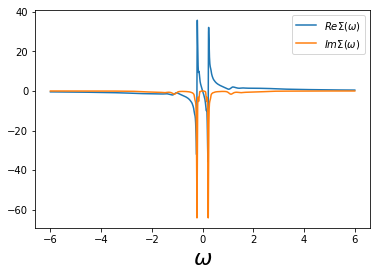

In [11]:
w = np.linspace(-6, 6, 2**12)
gloc = semi_circle_hiltrans(w + 1e-3j)
#gloc= 0.0
gloc, sigma_loc = dmft_loop(gloc, w, 3.3, 100, 100)

#plt.plot(w, -gloc.imag, lw=3, label=r'$\pi  A(\omega)$')
plt.plot(w, sigma_loc.real, '-', label=r'$Re \Sigma(\omega)$')
plt.plot(w, sigma_loc.imag, '-', label=r'$Im \Sigma(\omega)$')
plt.xlabel(r'$\omega$')
plt.legend(loc=0)
#plt.ylim([0, 0.1])
#plt.xlim([-1, 1])
plt.show()

## The effect of the self-consistency condition
 
1. The DMFT implementation is an iterative process which requires a certain number of loops before convergence is reached. But one needs a starting point, i.e. one needs to input an initial guess of the spectral function. Can you say which is the starting guess in the DMFT implementation considered above?  

2. For $U < Uc_2$, run the code with *just one dmft iteration*, using the same values of $U$ that you have employed above. This one-loop run corresponds to the solution of the Single Impurity Anderson Model SIAM (or **Kondo Model**, see Marc's lecture notes) for a semi-circular conduction band. Compare the spectral function $A(\omega)$ of the one-iteration loop with the fully converged one. Do you see the MIT?  

3. Repeat the same excercise of point 2., this time inputing no bath (i.e. the intial guess is zero), and always one iteration loop. This means that you are essentially solving the isolated atom problem with on-site interaction $U$. Draw a conclusions about the effect of the self-conistency in solving the MIT problem.

# Let's start now

## Excercises

We shall first work at low temperature, choose $\beta=100$. The imaginary part of the Green's function $A(\omega)= -\Im G(\omega)/\pi$ can be directly connected to physical observables (e.g. spectral functions) or transport (e.g. specific heat).

## The Metal-to-Insulator Transition

1. Plot first $A(\omega)$ in the case $U=0$. This is the semicircular density of states used in the DMFT code, i.e. $-\Im G(\omega)/\pi= D(\omega)$. The system is in this case "halffilled", i.e. there is one elctron per atomic orbital. Can you indicate then where the occupied states are on the plot of the density of states $A(\omega)$? Why the system is a metal according to the band theory of solids?

2. Run the code for several values of $U$ (the half-bandwidth is set $D=1$) to check out the metal-insulator transition. Display $A(\omega)$ for some rapresentative values of $U$, in the metallic and insulating sides.

3. Approach the MIT at $Uc_2$ (metal to insulator) from below ($U< Uc_2$) and describe how the different contributions to the $A(\omega)$ (quasiparticle peak and Hubbard bands) evolve as you get close to the critical value. Why can we state that for $U> Uc_2$ the system is finally insulating? Give your extimation of  $Uc_2$. 

4. At the MIT point, the quaiparticle peak has completely disappered. But where is the spectral weight of the peak gone? Explain why we expect that the total spectral weight [i.e. the area under the curve $A(\omega)$] is conserved.


## Selfenergy

1. Plot now the real part and the imaginary part of the self-energy $\Sigma(\omega)$, first for $U< Uc_2$, then for $U \ge Uc_2$. Use the same values of $U$ that you have used above.
2. We are going now to concentrate on the low energy part $\omega\to 0$, where a quasiparticle peak is observable in the metallic phase, even for values of $U$ very close to the MIT. The Fermi liquid theory of metals states that the selfenergy is a regular function of $\omega$, which can be Taylor expanded: $$
\Re\Sigma \simeq \mu_0 + \alpha \omega+ O(\omega^2) \quad \quad
\Im\Sigma \sim \omega^2+ O(\omega^3)
$$
For which values of $U$ can we state that the system is in a Fermi liquid state?
3. We shall now see how the Fermi liquid theory may be useful to understand the beahvior of spectral functions. The local Green's function (entering the DMFT self-consistency condition) is the Hilbert transform of the lattice Green's function $G(\omega,\varepsilon)$ 
$$
G_{loc}(\omega)= \,\int D(\varepsilon) \, G(\omega, \varepsilon)\, d\varepsilon=
\,\int D(\varepsilon)/\left[ \omega-\varepsilon- \Sigma(\omega) \right] \, d\varepsilon $$
where $D(\varepsilon)= -(1/\pi) \Im G_{loc}(\varepsilon,U=0)$ and in our case (infinite dimension) $\Sigma(\omega)$ is independent of $\varepsilon$. Show that the lattice Green's function can be written within the Fermi liquid theory ($\omega\to0$) as a almost free-particle Green's function $$
G(\omega, \xi)\sim \frac{Z}{\omega-\xi} $$
where the main difference is the factor $Z$, known as *quasi-particle renormalization factor* .
    * Evaluate $Z$ for different values of $U$ (use the real part of the self-energy) and plot it as a function of $U$. Explain why $Z$ is useful to describe the MIT. *Hint: in order to extract a part of the Green's function array (let's call it e.g. $gx$) between frequencies, e.g. $[-2,2]$, define a logical array of frequencies $w_r= (w< 2 )*(w> -2)$, then the desired reduced Green's function array is simply given by $gx[w_r]$.*
    * Calculate (for a couple of $U$ values used above) the area under the quasiparticle peaks and plot them as a function of $U$. Relate this area with the quasiparticle residue $Z$ (you should plot them as a function of $U$). 
    * Determine the exact relation between the quasiparticle peak and $Z$ also analytically. Explain finally why it is said that *a Mott transition is a breaking of the Fermi Liquid Theory*.


# First order transition

The MIT is a first order transiton, i.e. there is a region of coexistence between the insulator and the metallic phase.
1. Show that there is an interval of $U$ where DMFT self-consistency provides two solutions. Determine the $Uc_1$, i.e. the critical value of $U$ where the insulating state changes into a metal by reducing $U$. *(Hint: you have to use an appropriate starting guess to obtain the insulating solution, start your investigations with values of $U$ in the insulating side).*
2. Is $Z$ the right parameter to describe the insulator-to-metal transition too? Argument your answer. 

# $T-U \,$ phase diagram and the $T$-driven transition

1. Run now the code for higher temperatures $T$, i.e. lower inverse temperatures $\beta= 75, 50, 25$ and determine for each temperature $T$ the $Uc_1$ and the $Uc_2$. Sketch then the coexistence region in the $T-U$ plane.
2. Observe the shape of the coexistence region in the $T-U$ space. Fix the interaction $U$ inside this co-existence region (e.g. $U=2.9$) and systematically increase the temperature. Compare the different density of states. Can you now explain the phase-diagram of VO$_2$, in particular the unusual not-metallic behavior at high temperature? 
3. Can you give an interpretation of this physical behaviour with temperature in terms of the associated SIAM model, i.e. a spin impurity fluctuating with temperature in a bath of free electrons?